In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [58]:
def wiek_uprosc(wiek):
    if wiek <= 18:
        return "18m"
    elif wiek == 19:
        return "19"
    elif wiek == 20:
        return "20"
    else:
        return "21p"

def przystosuj_do_regresji(rok):
    wyniki = pd.read_csv("../dane/przetworzone/sumy_laureaty_{}_znorm.csv".format(rok),
                         low_memory=False)
    szkoly = pd.read_csv("../dane/szkoly2014.csv")  # wystarczy?

    # dla LOU
    szkoly.specjalna.fillna(False, inplace=True)
    szkoly.publiczna.fillna(True, inplace=True)
    
    df = wyniki.merge(szkoly, on="id_szkoly", how="left")
    
    df["wielkosc_miejscowosci_log10"] = np.log10(df["wielkosc_miejscowosci"] + 1000)
    
    df["wielkosc_miejscowosci_log10"]  = (df["wielkosc_miejscowosci_log10"] - df["wielkosc_miejscowosci_log10"].mean())/df["wielkosc_miejscowosci_log10"].std()
    
    df['wiek'] = (rok - df.rocznik).apply(wiek_uprosc)
    
    df['niepubliczna'] = df['publiczna'].apply(lambda x: not x)
    
    id_do_uczniow_log10 = df["id_szkoly"].value_counts().apply(np.log10)
    df["uczniow_w_szkole_log10"] = df["id_szkoly"].map(id_do_uczniow_log10)
    df["uczniow_w_szkole_log10"] = (df["uczniow_w_szkole_log10"] - df["uczniow_w_szkole_log10"].mean())/df["uczniow_w_szkole_log10"].std()
    
    return df

In [53]:
formula_rhs = """ ~ C(plec) + C(typ_szkoly) + C(rodzaj_gminy, Treatment(reference='miejska'))
             + wielkosc_miejscowosci_log10 + C(wiek, Treatment(reference='19'))
             + niepubliczna + dla_doroslych + specjalna"""

# na razie bez
# + uczniow_w_szkole_log10
# bo to obejuje tylko zdających

In [41]:
df = przystosuj_do_regresji(2014)

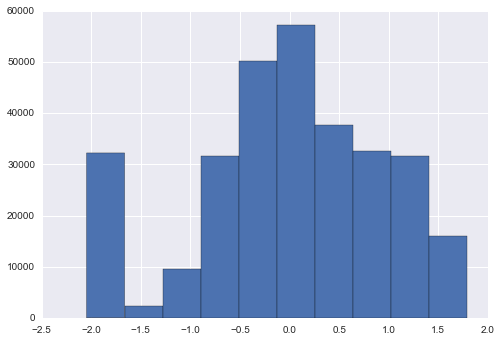

In [10]:
df["wielkosc_miejscowosci_log10"].hist()

In [42]:
reg_pol = smf.ols("j_polski_podstawowa" + formula_rhs, data=df).fit()
reg_pol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     j_polski_podstawowa   R-squared:                       0.197
Model:                             OLS   Adj. R-squared:                  0.197
Method:                  Least Squares   F-statistic:                     4600.
Date:                 Fri, 31 Jul 2015   Prob (F-statistic):               0.00
Time:                         22:09:13   Log-Likelihood:            -3.9181e+05
No. Observations:               300216   AIC:                         7.836e+05
Df Residuals:                   300199   BIC:                         7.838e+05
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       0.3120      0.003    103.052      0.000         0.306     0.318
C(plec)[T.m]                                                                   -0.1612      0.003    -48.085      0.000        -0.168    -0.155
C(typ_szkoly)[T.LOU]                                                            0.0834      0.032      2.622      0.009         0.021     0.146
C(typ_szkoly)[T.LP]                                                            -0.4767      0.013    -36.234      0.000        -0.502    -0.451
C(typ_szkoly)[T.T]                                                             -0.1236      0.009    -14.361      0.000        -0.140    -0.107
C(typ_szkoly)[T.TU]                                                            -0.1602      0.025     -6.371      0.000        -0.209    -0.111
C(rodzaj_gminy, Treatment(reference='miejska'))[T.dzielnica m.st. Warszawy]    -0.0977      0.008    -11.534      0.000        -0.114    -0.081
C(rodzaj_gminy, Treatment(reference='miejska'))[T.miejsko-wiejska]              0.0747      0.006     12.673      0.000         0.063     0.086
C(rodzaj_gminy, Treatment(reference='miejska'))[T.wiejska]                      0.0585      0.011      5.331      0.000         0.037     0.080
C(wiek, Treatment(reference='19'))[T.18m]                                       0.3378      0.019     18.070      0.000         0.301     0.374
C(wiek, Treatment(reference='19'))[T.20]                                       -0.3990      0.009    -46.796      0.000        -0.416    -0.382
C(wiek, Treatment(reference='19'))[T.21w]                                      -0.6590      0.010    -64.163      0.000        -0.679    -0.639
niepubliczna[T.True]                                                           -0.0238      0.008     -2.900      0.004        -0.040    -0.008
dla_doroslych[T.True]                                                          -0.1880      0.012    -15.727      0.000        -0.211    -0.165
specjalna[T.True]                                                               0.2368      0.054      4.375      0.000         0.131     0.343
wielkosc_miejscowosci_log10                                                     0.0958      0.003     34.228      0.000         0.090     0.101
uczniow_w_szkole_log10                                                          0.1716      0.002     75.418      0.000         0.167     0.176
==============================================================================
Omnibus:                      328.392   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.

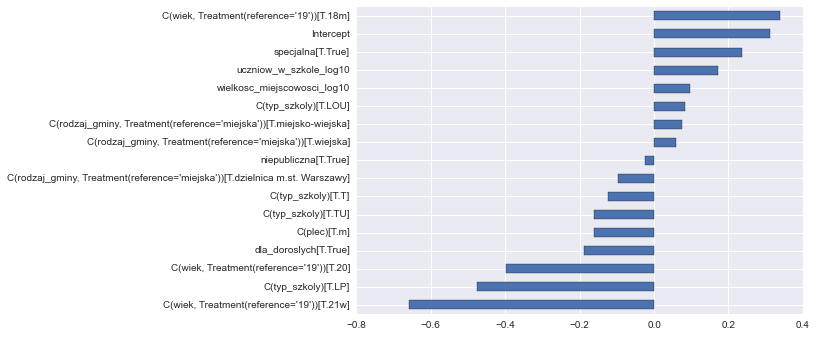

In [43]:
reg_pol.params.order().plot(kind="barh")

In [44]:
reg_mat = smf.ols("matematyka_podstawowa" + formula_rhs, data=df).fit()
reg_ang = smf.ols("j_angielski_podstawowa" + formula_rhs, data=df).fit()

In [45]:
zebrane = pd.DataFrame({"pol": reg_pol.params,
                        "mat": reg_mat.params,
                        "ang": reg_ang.params})
bledy = pd.DataFrame({"pol": reg_pol.HC1_se,
                      "mat": reg_mat.HC1_se,
                      "ang": reg_ang.HC1_se})

In [46]:
# zebrane.index.tolist()

In [47]:
slownik = {'Intercept': "wyraz wolny",
 'C(plec)[T.m]': "mężczyzna",
 'C(typ_szkoly)[T.LOU]': "liceum ogólnokształcące uzupełniające",
 'C(typ_szkoly)[T.LP]': "liceum profilowane",
 'C(typ_szkoly)[T.T]': "technikum",
 'C(typ_szkoly)[T.TU]': "technikum uzupełniające",
 "C(rodzaj_gminy, Treatment(reference='miejska'))[T.dzielnica m.st. Warszawy]": "Warszawa",
 "C(rodzaj_gminy, Treatment(reference='miejska'))[T.miejsko-wiejska]": "gmina miejsko-wiejska",
 "C(rodzaj_gminy, Treatment(reference='miejska'))[T.wiejska]": "gmina wiejska",
 "C(wiek, Treatment(reference='19'))[T.18m]": "18 lat i mniej",
 "C(wiek, Treatment(reference='19'))[T.20]": "20 lat",
 "C(wiek, Treatment(reference='19'))[T.21p]": "21 lat i więcej",
 'niepubliczna[T.True]': "szkoła niepubliczna",
 'dla_doroslych[T.True]': "szkoła dla dorosłych",
 'specjalna[T.True]': "szkoła specjalna",
 'wielkosc_miejscowosci_log10': "wielkość miejscowości (skala log)"}

In [48]:
zebrane = zebrane.rename(index=slownik)
bledy = bledy.rename(index=slownik)

In [49]:
reg_pol.rsquared

0.19688203106559654

In [50]:
reg_mat.rsquared

0.33313747589647891

In [51]:
reg_ang.rsquared

0.28213522402153646

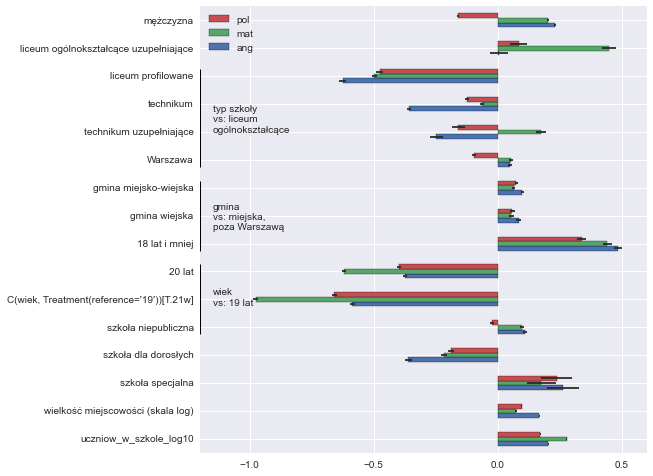

In [52]:
# plt.style.use("ggplot")

zebrane \
  .iloc[::-1] \
  .drop("wyraz wolny") \
  .plot(kind="barh", xerr=bledy, figsize=(8,8), legend="reverse")
#plt.legend(loc="upper right")
plt.text(-1.15, 4.8, "wiek\nvs: 19 lat")
plt.vlines(-1.2, 3.75, 6.25, linewidth=1)
plt.text(-1.15, 7.5, "gmina\nvs: miejska,\npoza Warszawą")
plt.vlines(-1.2, 6.75, 9.25, linewidth=1)
plt.text(-1.15, 11, "typ szkoły\nvs: liceum\nogólnokształcące")
plt.vlines(-1.2, 9.75, 13.25, linewidth=1)

In [61]:
def wspolczynniki_w_latach(przedmiot):
    lata = range(2010, 2015)
    dane = [przystosuj_do_regresji(rok) for rok in lata]
    dopasowania = [smf.ols(przedmiot + formula_rhs, data=df).fit() for df in dane]
    korelacje = pd.DataFrame({rok: reg.params for rok, reg in zip(lata, dopasowania)})
    korelacje = korelacje.rename(index=slownik)
    return korelacje

In [69]:
korelacje_mat = wspolczynniki_w_latach("matematyka_podstawowa")

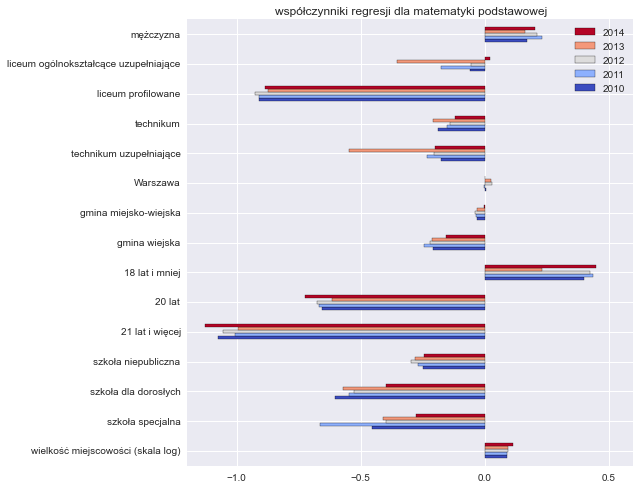

In [70]:
korelacje_mat \
  .iloc[::-1] \
  .drop("wyraz wolny") \
  .plot(kind="barh", figsize=(8,8), legend="reverse", colormap="coolwarm",
        title="współczynniki regresji dla matematyki podstawowej")

In [62]:
korelacje_pol = wspolczynniki_w_latach("j_polski_podstawowa")

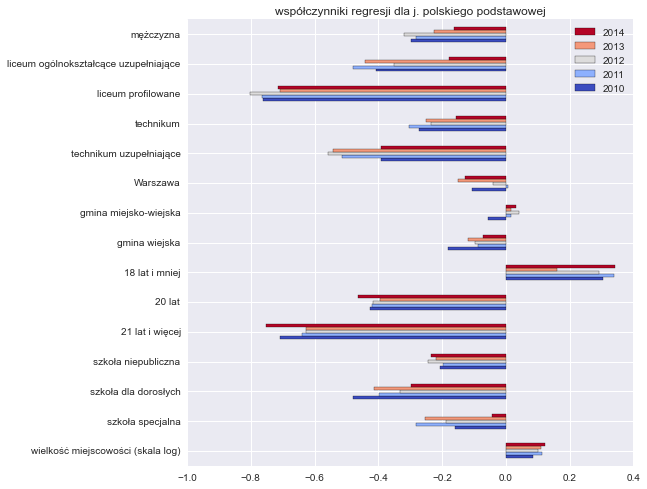

In [63]:
korelacje_pol \
  .iloc[::-1] \
  .drop("wyraz wolny") \
  .plot(kind="barh", figsize=(8,8), legend="reverse", colormap="coolwarm",
        title="współczynniki regresji dla j. polskiego podstawowej")

In [64]:
korelacje_ang = wspolczynniki_w_latach("j_angielski_podstawowa")

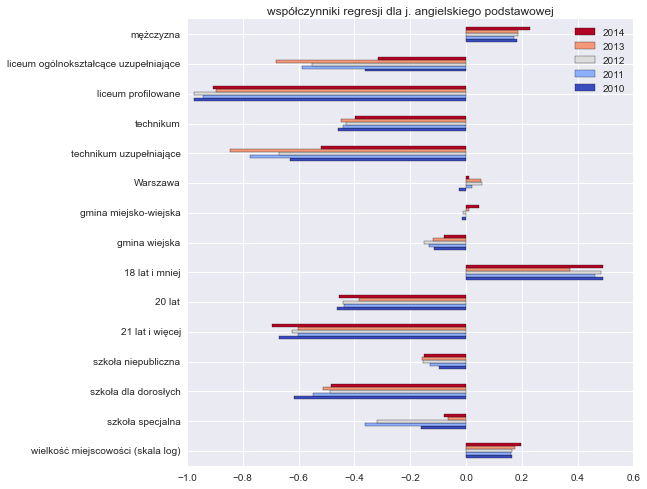

In [65]:
korelacje_ang \
  .iloc[::-1] \
  .drop("wyraz wolny") \
  .plot(kind="barh", figsize=(8,8), legend="reverse", colormap="coolwarm",
        title="współczynniki regresji dla j. angielskiego podstawowej")

wyraz wolny                              0.291763
mężczyzna                                0.191384
liceum ogólnokształcące uzupełniające   -0.499039
liceum profilowane                      -0.939258
technikum                               -0.436183
technikum uzupełniające                 -0.688464
Warszawa                                 0.023662
gmina miejsko-wiejska                    0.006421
gmina wiejska                           -0.118944
18 lat i mniej                           0.459471
20 lat                                  -0.435437
21 lat i więcej                         -0.639646
szkoła niepubliczna                     -0.138234
szkoła dla dorosłych                    -0.530394
szkoła specjalna                        -0.198337
wielkość miejscowości (skala log)        0.171827
dtype: float64

In [71]:
zebrane_latami = pd.DataFrame({"pol": korelacje_pol.mean(axis=1),
                               "mat": korelacje_mat.mean(axis=1),
                               "ang": korelacje_ang.mean(axis=1)})
bledy_latami = pd.DataFrame({"pol": korelacje_pol.std(axis=1),
                             "mat": korelacje_mat.std(axis=1),
                             "ang": korelacje_ang.std(axis=1)})

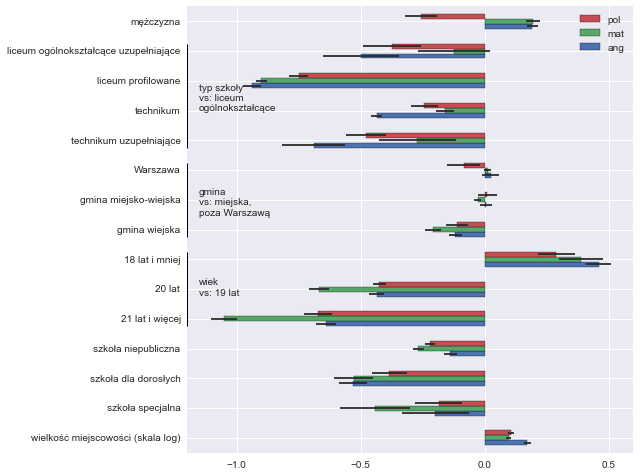

In [72]:
zebrane_latami \
  .iloc[::-1] \
  .drop("wyraz wolny") \
  .plot(kind="barh", xerr=bledy_latami, figsize=(8,8), legend="reverse")
#plt.legend(loc="upper right")
plt.text(-1.15, 4.8, "wiek\nvs: 19 lat")
plt.vlines(-1.2, 3.75, 6.25, linewidth=1)
plt.text(-1.15, 7.5, "gmina\nvs: miejska,\npoza Warszawą")
plt.vlines(-1.2, 6.75, 9.25, linewidth=1)
plt.text(-1.15, 11, "typ szkoły\nvs: liceum\nogólnokształcące")
plt.vlines(-1.2, 9.75, 13.25, linewidth=1)